# Machine Learning for String Field Theory

H. Erbin, R. Finotello, M. Kudrna, M. Schnabl

---
---

## Abstract

In the framework of bosonic Open String Field Theory (OSFT), we consider several observables characterised by conformal weight and type, and the position of vacua in the potential for various values of truncated mass level. We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

## Synopsis

In this notebook we compute the predictions of the model independent analysis using a neural network to predict both real and imaginary parts of the extrapolated label.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        pass

In [3]:
import os
import logging

# set less logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

## Training and Test Sets

In [4]:
import pandas as pd

df     = pd.read_csv('./data/full.csv')
dlumps = pd.read_csv('./data/dlumps.csv')

# keep only reliable samples
dlumps = dlumps.loc[dlumps['weight'] < 1.5]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2379 entries, 0 to 2378
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   exp_re  2379 non-null   float64
 1   exp_im  2379 non-null   float64
 2   weight  2379 non-null   float64
 3   type    2379 non-null   float64
 4   pca_1   2379 non-null   float64
 5   pca_2   2379 non-null   float64
 6   pca_3   2379 non-null   float64
 7   pca_4   2379 non-null   float64
 8   pca_5   2379 non-null   float64
 9   pca_6   2379 non-null   float64
 10  pca_7   2379 non-null   float64
 11  pca_8   2379 non-null   float64
 12  pca_9   2379 non-null   float64
 13  pca_10  2379 non-null   float64
dtypes: float64(14)
memory usage: 260.3 KB


In [6]:
dlumps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 18
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   exp_re  12 non-null     float64
 1   exp_im  12 non-null     float64
 2   weight  12 non-null     float64
 3   type    12 non-null     float64
 4   pca_1   12 non-null     float64
 5   pca_2   12 non-null     float64
 6   pca_3   12 non-null     float64
 7   pca_4   12 non-null     float64
 8   pca_5   12 non-null     float64
 9   pca_6   12 non-null     float64
 10  pca_7   12 non-null     float64
 11  pca_8   12 non-null     float64
 12  pca_9   12 non-null     float64
 13  pca_10  12 non-null     float64
dtypes: float64(14)
memory usage: 1.4 KB


We divide it into training/validation/test sets with 80% of the samples in the training set, 10% in the validation and 10% in the test fold.

In [7]:
from sklearn.model_selection import train_test_split

# fix the random state
RAND = 123

# split the set
train, test = train_test_split(df, train_size=0.8, shuffle=True, random_state=RAND)
val, test   = train_test_split(test, train_size=0.5, shuffle=True, random_state=RAND)

print('Training fraction: {:.2f}.'.format(train.shape[0] / df.shape[0]))
print('Validation fraction: {:.2f}.'.format(val.shape[0] / df.shape[0]))
print('Test fraction: {:.2f}.'.format(test.shape[0] / df.shape[0]))

Training fraction: 0.80.
Validation fraction: 0.10.
Test fraction: 0.10.


We then add the double lumps in the validation set (half of them) and test set (half of them):

In [8]:
# divide validation and test sets
dlumps_val  = dlumps.sample(frac=0.5, random_state=RAND)
dlumps_test = dlumps.loc[~dlumps.index.isin(dlumps_val.index)]
dlumps_test = dlumps_test.sample(frac=1, random_state=RAND)

# add to validation and test sets
val  = pd.concat([val, dlumps_val], axis=0)
test = pd.concat([test, dlumps_test], axis=0)

# reshuffle the sets
val  = val.sample(frac=1, random_state=RAND)
test = test.sample(frac=1, random_state=RAND)

In [9]:
# divide the labels from the features
X_train = train.drop(columns=['exp_re', 'exp_im'])
X_val   = val.drop(columns=['exp_re', 'exp_im'])
X_test  = test.drop(columns=['exp_re', 'exp_im'])

y_train = train[['exp_re', 'exp_im']]
y_val   = val[['exp_re', 'exp_im']]
y_test  = test[['exp_re', 'exp_im']]

Next we scale the input for the neural networks:

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import os

# define the scaler
std_scl = StandardScaler()

# scale the data
X_train = pd.DataFrame(std_scl.fit_transform(X_train), columns=X_train.columns)
X_val   = pd.DataFrame(std_scl.transform(X_val), columns=X_val.columns)
X_test  = pd.DataFrame(std_scl.transform(X_test), columns=X_test.columns)

# scale the labels
minmax  = MinMaxScaler()
y_train = pd.DataFrame(minmax.fit_transform(y_train), columns=y_train.columns)
y_val   = pd.DataFrame(minmax.transform(y_val), columns=y_val.columns)
y_test  = pd.DataFrame(minmax.transform(y_test), columns=y_test.columns)

# save the scaler
os.makedirs('./models', exist_ok=True)
joblib.dump(std_scl, './models/standard_scaler.pkl')

['./models/standard_scaler.pkl']

In [11]:
# save labels and test set to file
X_train.to_csv('./data/X_train.csv', index=False)
X_val.to_csv('./data/X_val.csv', index=False)
X_test.to_csv('./data/X_test.csv', index=False)

y_train.to_csv('./data/y_train.csv', index=False)
y_val.to_csv('./data/y_val.csv', index=False)
y_test.to_csv('./data/y_test.csv', index=False)

# save also one copy for cross-validation
pd.concat([X_train, X_val], axis=0).to_csv('./data/X_train_cv.csv', index=False)
pd.concat([y_train, y_val], axis=0).to_csv('./data/y_train_cv.csv', index=False)

## Support Vector Machines

As a first step we try the _Gaussian kernel trick_ for SVM.

In [12]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm         import SVR
from skopt.space         import Real
import joblib

svr  = SVR(kernel='rbf')
est   = MultiOutputRegressor(svr, n_jobs=-1)
space = {'estimator__C':       Real(1.0e-4, 1.0e2, prior='log-uniform'),
         'estimator__epsilon': Real(0.0, 10.0),
         'estimator__gamma':   Real(1.0e-4, 1.0e1, prior='log-uniform'),
        }

# save the estimator
joblib.dump(est, './models/svr.pkl')
joblib.dump(space, './models/svr_hypers.pkl')

['./models/svr_hypers.pkl']

The we train the model:

In [13]:
!python3 ./scripts/multiout-cv.py -t './data/X_train_cv.csv' -l './data/y_train_cv.csv' \
                                  -e './models/svr.pkl' -p './models/svr_hypers.pkl' \
                                  -cv 9 -n 100 -r {RAND}

/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
BayesSearchCV trained in 246.901 seconds.


In [14]:
import json
import re

with open('./models/svr_hypers.json') as f:
    params = json.load(f)
params = pd.DataFrame(params, index=['svr']).rename(columns=lambda c: re.sub('estimator__', '', c))
print('Best hyperparameters: ')
params

Best hyperparameters: 


,C,epsilon,gamma
svr,11.837298,0.0,10.0


In [15]:
%%script false --no-raise-error

!python3 ./scripts/multiout-train.py -t './data/X_train.csv' -l './data/y_train.csv' -e './models/svr.pkl'

The we compute the predictions on the validation set:

In [16]:
%%script false --no-raise-error

!python3 ./scripts/multiout-predict.py -t './data/X_val.csv' -l './data/y_val.csv' -e './models/svr.pkl' -o 'svr_val'

In [17]:
%%script false --no-raise-error

import pandas as pd
pd.read_json('./metrics/svr_val.json').set_index(pd.Index(['Re(exp)', 'Im(exp)']))

And the predictions on the test set:

In [18]:
!python3 ./scripts/multiout-predict.py -t './data/X_test.csv' -l './data/y_test.csv' -e './models/svr.pkl' -o 'svr_test'

MultiOutputRegressor predicted in 0.304 seconds.


In [19]:
import pandas as pd
pd.read_json('./metrics/svr_test.json').set_index(pd.Index(['Re(exp)', 'Im(exp)']))

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
Re(exp),232,0.010003,0.004092,0.015914,0.100014,0.035924,0.835917
Im(exp),232,0.000527,-0.000161,0.001215,0.022957,0.004232,0.971349


In [20]:
%%script false --no-raise-error

!python3 ./scripts/plots.py -gt './data/y_val.csv' -pl './predictions/svr_val.csv' -o 'svr_val'

In [21]:
%%script false --no-raise-error

from IPython.display import Image
Image('./img/svr_val_exp_re_plot.png', width=480)

In [22]:
%%script false --no-raise-error

from IPython.display import Image
Image('./img/svr_val_exp_im_plot.png', width=480)

In [23]:
%%script false --no-raise-error

from IPython.display import Image
Image('./img/svr_val_res_dist.png', width=480)

In [24]:
%%script false --no-raise-error

from IPython.display import Image
Image('./img/svr_val_res_plot.png', width=480)

In [25]:
!python3 ./scripts/plots.py -gt './data/y_test.csv' -pl './predictions/svr_test.csv' -o 'svr_test'

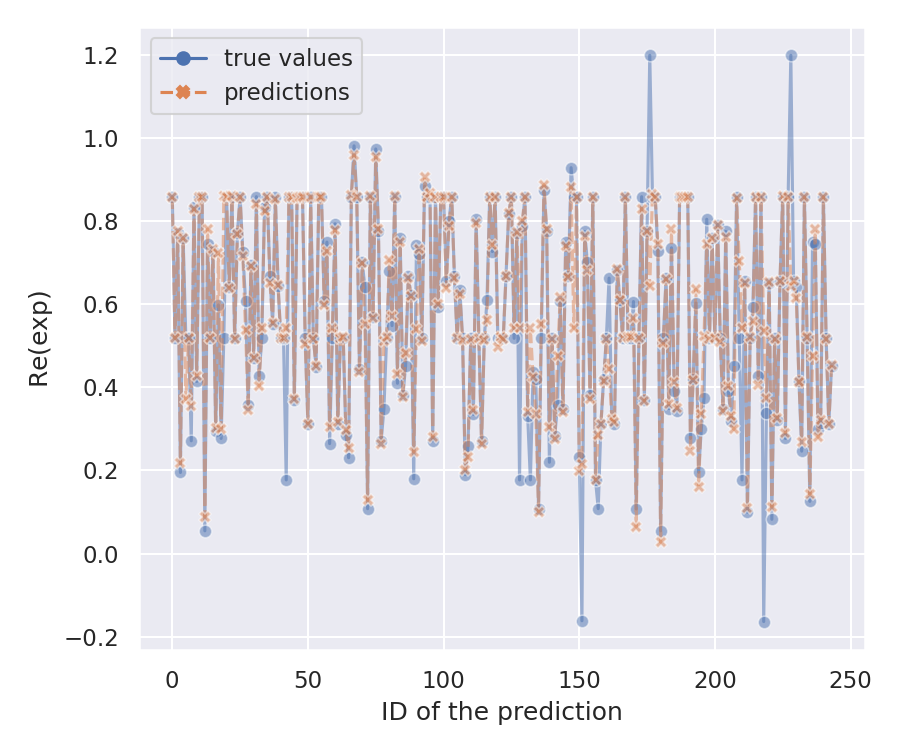

In [26]:
from IPython.display import Image
Image('./img/svr_test_exp_re_plot.png', width=480)

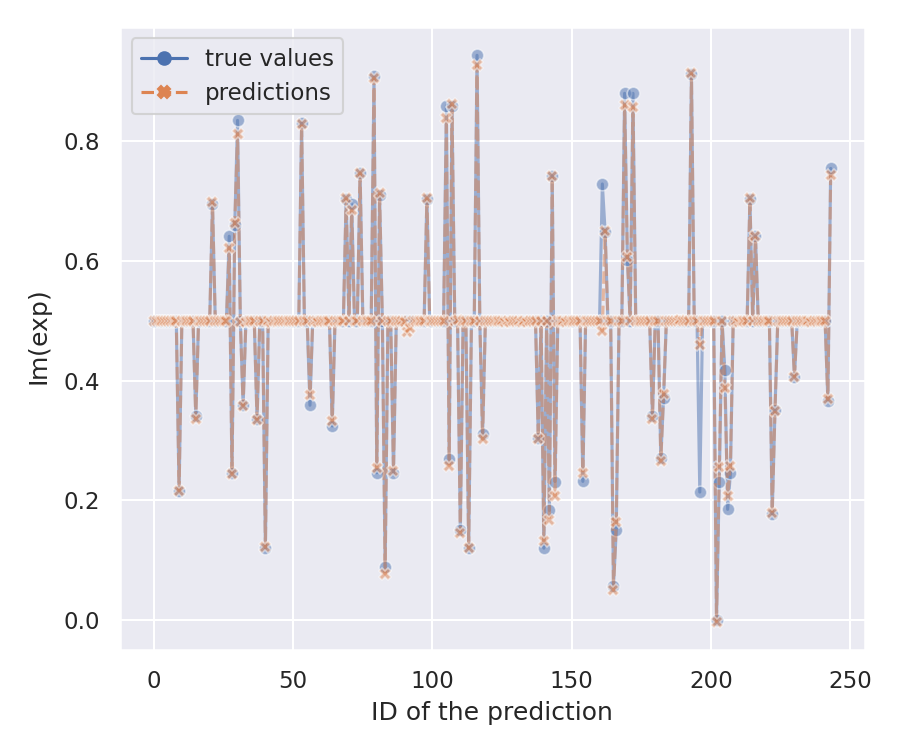

In [27]:
from IPython.display import Image
Image('./img/svr_test_exp_im_plot.png', width=480)

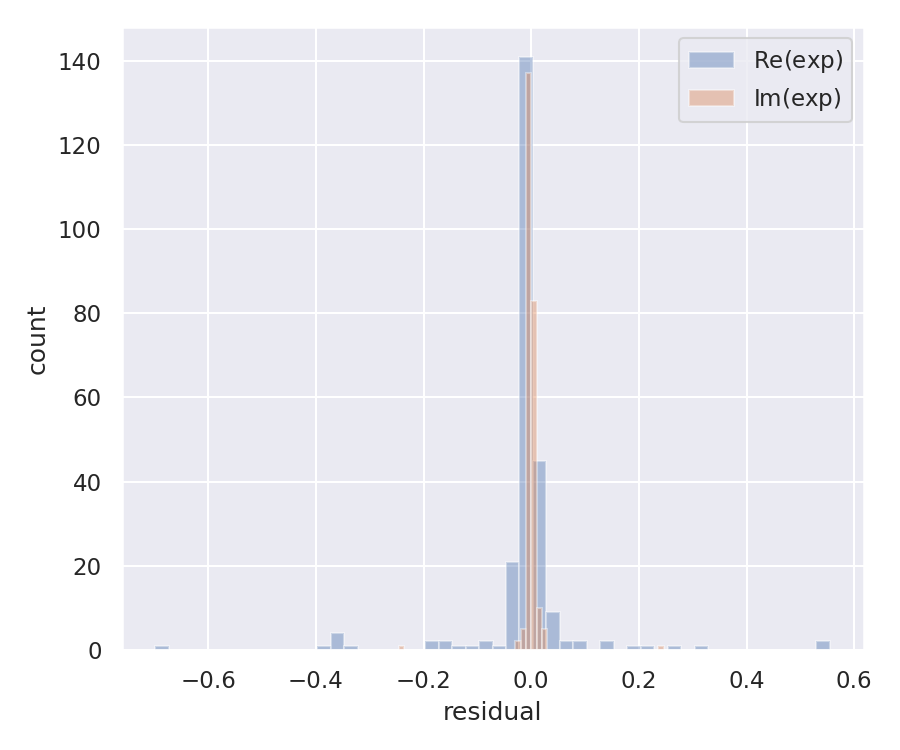

In [28]:
from IPython.display import Image
Image('./img/svr_test_res_dist.png', width=480)

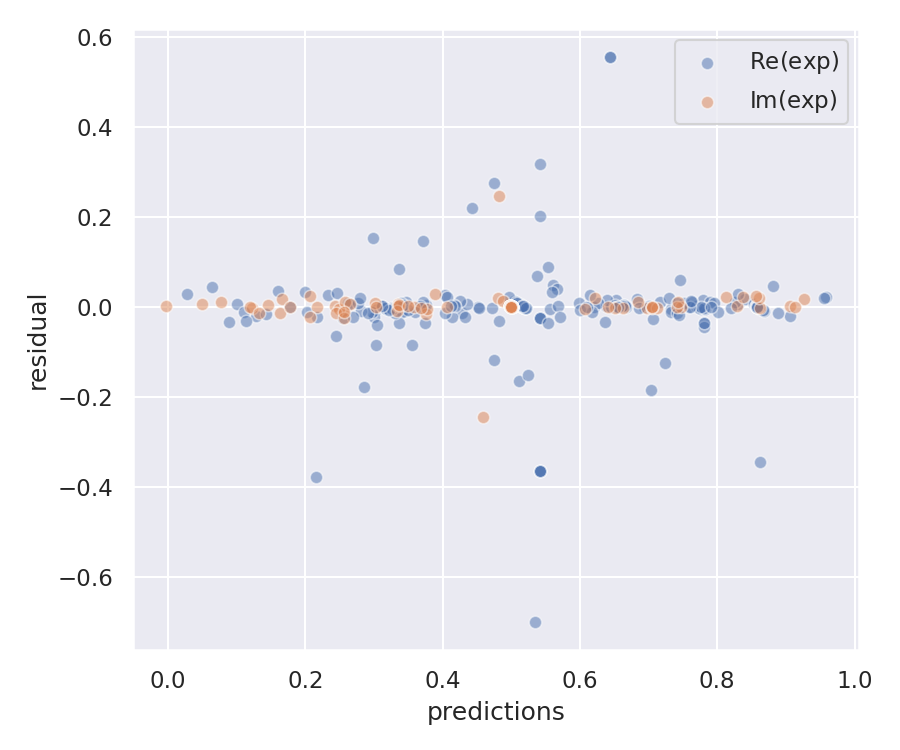

In [29]:
from IPython.display import Image
Image('./img/svr_test_res_plot.png', width=480)

## Gradient Boosted Decision Trees

We also take a look at the GBDT algorithm for comparison.

In [30]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm            import LGBMRegressor
from skopt.space         import Real, Integer
import joblib

gbdt  = LGBMRegressor(boosting_type='gbdt',
                      objective='regression',
                      subsample_freq=1,
                      n_jobs=-1,
                      importance_type='gain'
                     )
est   = MultiOutputRegressor(gbdt, n_jobs=-1)
space = {'estimator__num_leaves':       Integer(2, 25),
         'estimator__max_depth':        Integer(2, 25),
         'estimator__learning_rate':    Real(1e-3, 1e-1, prior='log-uniform'),
         'estimator__n_estimators':     Integer(1e2, 5e4, prior='log-uniform'),
         'estimator__subsample':        Real(0.1, 0.99),
         'estimator__colsample_bytree': Real(0.7, 1.0),
         'estimator__min_child_weight': Real(1.0e-3, 1.0e-1, prior='log-uniform'),
         'estimator__reg_alpha':        Real(1.0e0, 1.0e2, prior='log-uniform'),
         'estimator__reg_lambda':       Real(1.0e0, 1.0e3, prior='log-uniform'),
        }

# save the estimator
joblib.dump(est, './models/gbdt.pkl')
joblib.dump(space, './models/gbdt_hypers.pkl')

['./models/gbdt_hypers.pkl']

The we train the model:

In [31]:
!python3 ./scripts/multiout-cv.py -t './data/X_train_cv.csv' -l './data/y_train_cv.csv' \
                                  -e './models/gbdt.pkl' -p './models/gbdt_hypers.pkl' \
                                  -cv 9 -n 100 -r {RAND}

BayesSearchCV trained in 726.551 seconds.


In [32]:
import json
import re

with open('./models/gbdt_hypers.json') as f:
    params = json.load(f)
params = pd.DataFrame(params, index=['gbdt']).rename(columns=lambda c: re.sub('estimator__', '', c))
print('Best hyperparameters: ')
params

Best hyperparameters: 


,colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,num_leaves,reg_alpha,reg_lambda,subsample
gbdt,0.7,0.01027,25,0.1,50000,25,1.0,1000.0,0.99


In [33]:
%%script false --no-raise-error

!python3 ./scripts/multiout-train.py -t './data/X_train.csv' -l './data/y_train.csv' -e './models/gbdt.pkl'

The we compute the predictions on the validation set:

In [34]:
%%script false --no-raise-error

!python3 ./scripts/multiout-predict.py -t './data/X_val.csv' -l './data/y_val.csv' -e './models/gbdt.pkl' -o 'gbdt_val'

In [35]:
%%script false --no-raise-error

import pandas as pd
pd.read_json('./metrics/gbdt_val.json').set_index(pd.Index(['Re(exp)', 'Im(exp)']))

And the predictions on the test set:

In [36]:
!python3 ./scripts/multiout-predict.py -t './data/X_test.csv' -l './data/y_test.csv' -e './models/gbdt.pkl' -o 'gbdt_test'

MultiOutputRegressor predicted in 1.605 seconds.


In [37]:
import pandas as pd
pd.read_json('./metrics/gbdt_test.json').set_index(pd.Index(['Re(exp)', 'Im(exp)']))

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
Re(exp),232,0.006755,0.001779,0.011730,0.082187,0.032217,0.889199
Im(exp),232,0.001368,0.000222,0.002514,0.036991,0.012033,0.925612


In [38]:
%%script false --no-raise-error

!python3 ./scripts/plots.py -gt './data/y_val.csv' -pl './predictions/gbdt_val.csv' -o 'gbdt_val'

In [39]:
%%script false --no-raise-error

from IPython.display import Image
Image('./img/gbdt_val_exp_re_plot.png', width=480)

In [40]:
%%script false --no-raise-error

from IPython.display import Image
Image('./img/gbdt_val_exp_im_plot.png', width=480)

In [41]:
%%script false --no-raise-error

from IPython.display import Image
Image('./img/gbdt_val_res_dist.png', width=480)

In [42]:
%%script false --no-raise-error

from IPython.display import Image
Image('./img/gbdt_val_res_plot.png', width=480)

In [43]:
!python3 ./scripts/plots.py -gt './data/y_test.csv' -pl './predictions/gbdt_test.csv' -o 'gbdt_test'

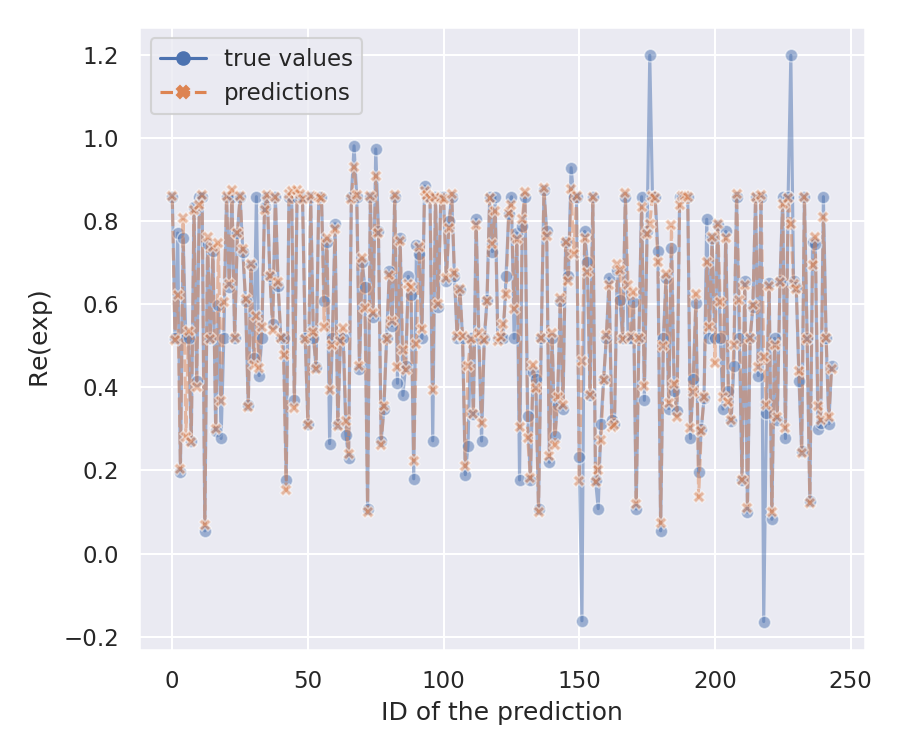

In [44]:
from IPython.display import Image
Image('./img/gbdt_test_exp_re_plot.png', width=480)

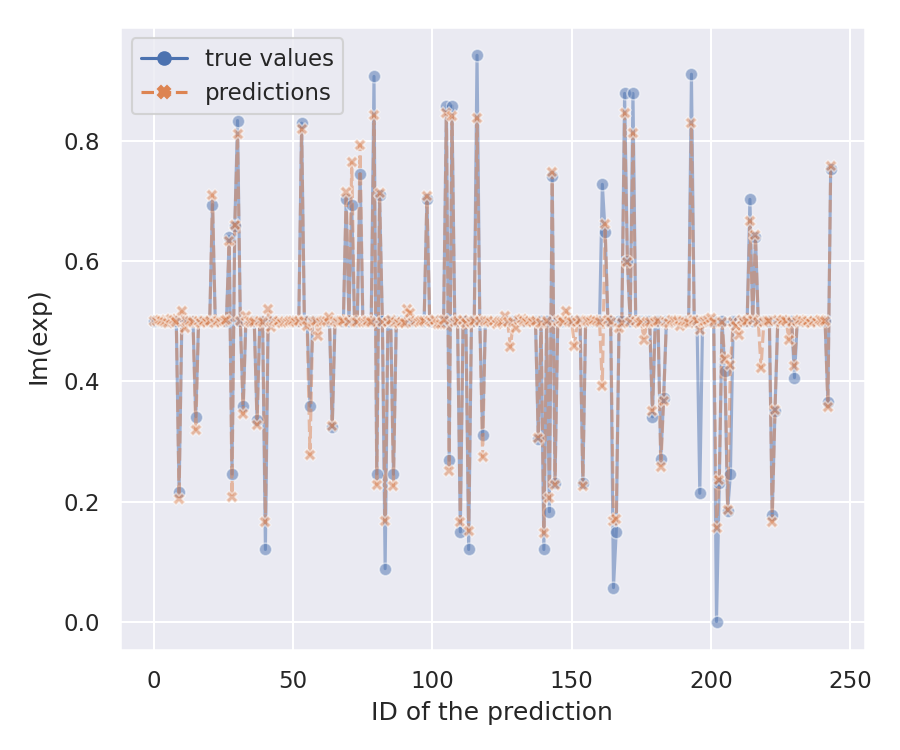

In [45]:
from IPython.display import Image
Image('./img/gbdt_test_exp_im_plot.png', width=480)

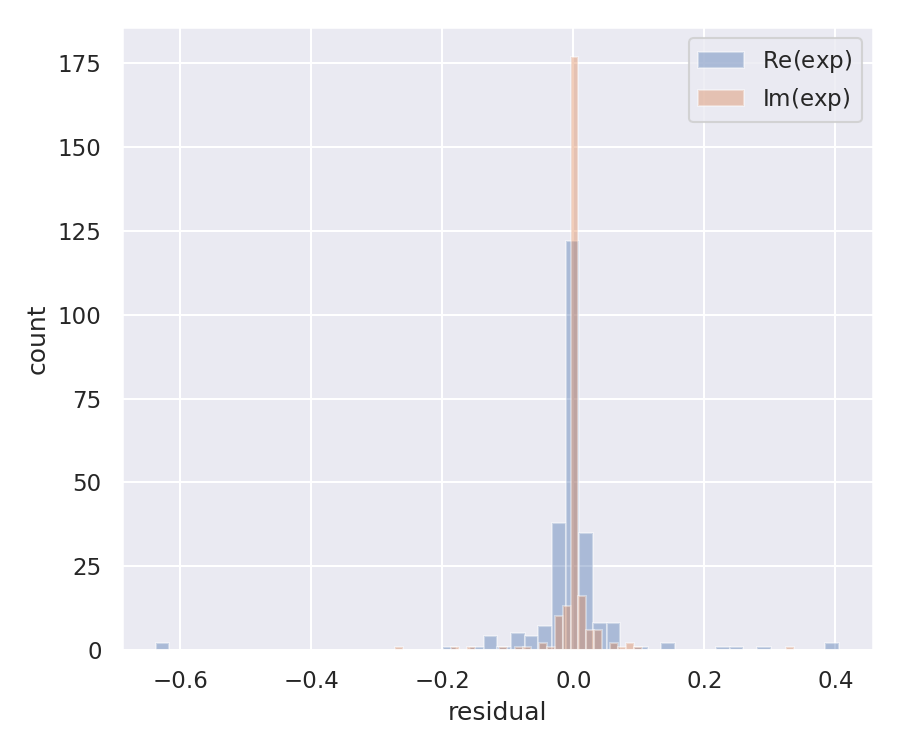

In [46]:
from IPython.display import Image
Image('./img/gbdt_test_res_dist.png', width=480)

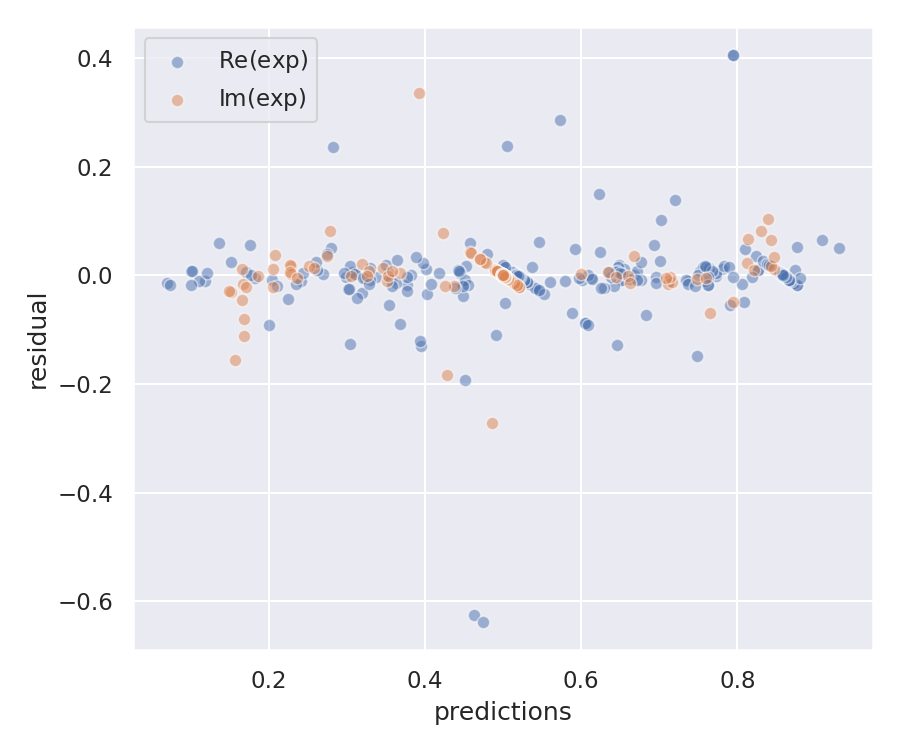

In [47]:
from IPython.display import Image
Image('./img/gbdt_test_res_plot.png', width=480)

## Neural Networks

We first build the architecture used in the analysis and then train it on the training fold.

In [77]:
import os

from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.initializers import GlorotUniform, Zeros
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

# reset graph
tf.keras.backend.clear_session()
tf.random.set_seed(RAND)

# define the input shape
input_shape = X_train.shape[1:]

# build the model
I = Input(shape=input_shape)
x = I

x = Dense(50, activation='relu')(x)
x = Dropout(rate=0.05)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(rate=0.05)(x)
x = Dense(10, activation='relu')(x)
x = Dense(10, activation='relu')(x)

# output layers
exp_re = Dense(1, name='exp_re')(x)
exp_im = Dense(1, name='exp_im')(x)

outputs = {'exp_re': exp_re,
           'exp_im': exp_im
          }
weights = {'exp_re': 0.75,
           'exp_im': 0.25
          }

# compile the model
model = Model(inputs=I, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              loss_weights=weights,
              metrics=['mse', 'mae']
             )

# save the model to file
os.makedirs('./models', exist_ok=True)
model.save('./models/ann.h5')

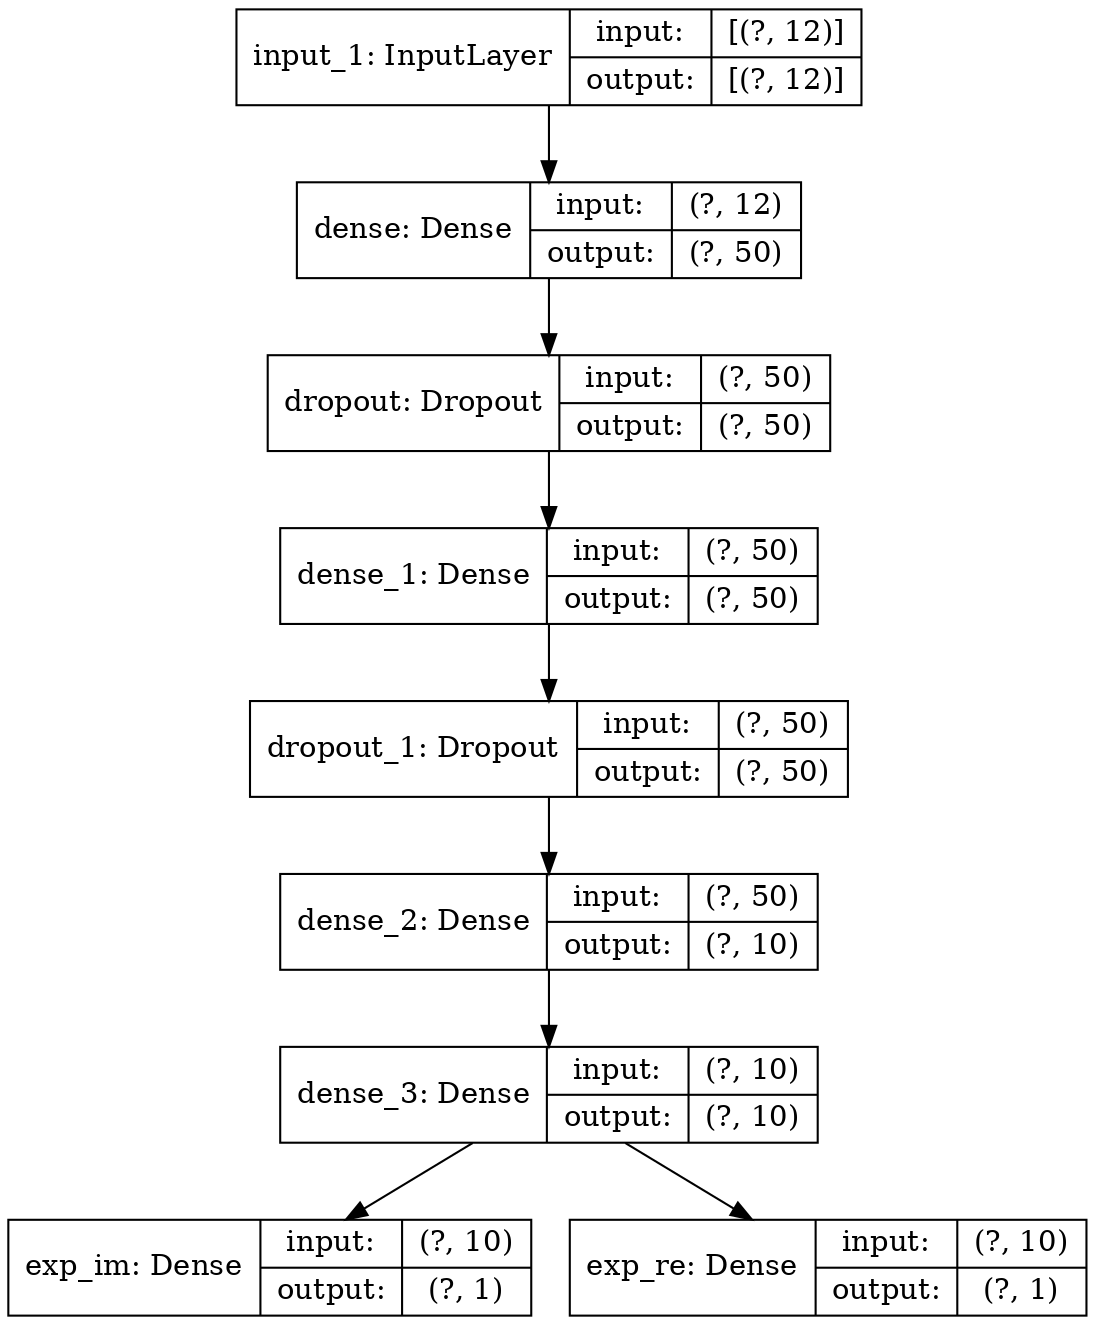

In [78]:
import os
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image

os.makedirs('./img', exist_ok=True)
model_dot = model_to_dot(model, show_shapes=True, dpi=150)
model_dot.write_pdf('./img/ann_arch.pdf')

Image(model_dot.create_png(), width=480)

In [79]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           650         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 50)           0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           2550        dropout[0][0]                    
______________________________________________________________________________________________

We then train the model:

In [80]:
!python3 ./scripts/train.py -tx './data/X_train.csv' -ty './data/y_train.csv' \
                            -vx './data/X_val.csv' -vy './data/y_val.csv' \
                            -m './models/ann.h5' -ep 20000 -b 32 -es 1000 -pf 0.3 -pp 750 -r 123

Training finished in 367.17 seconds.


In [81]:
!python3 ./scripts/history.py -d './data/history.csv' -s 0.1

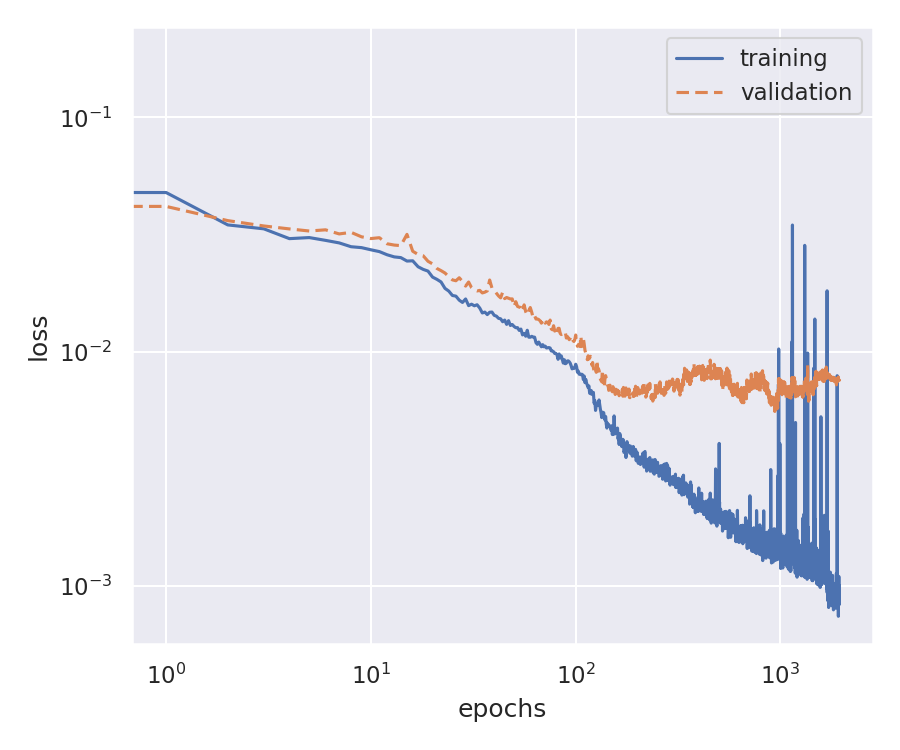

In [82]:
from IPython.display import Image
Image('./img/loss.png', width=480)

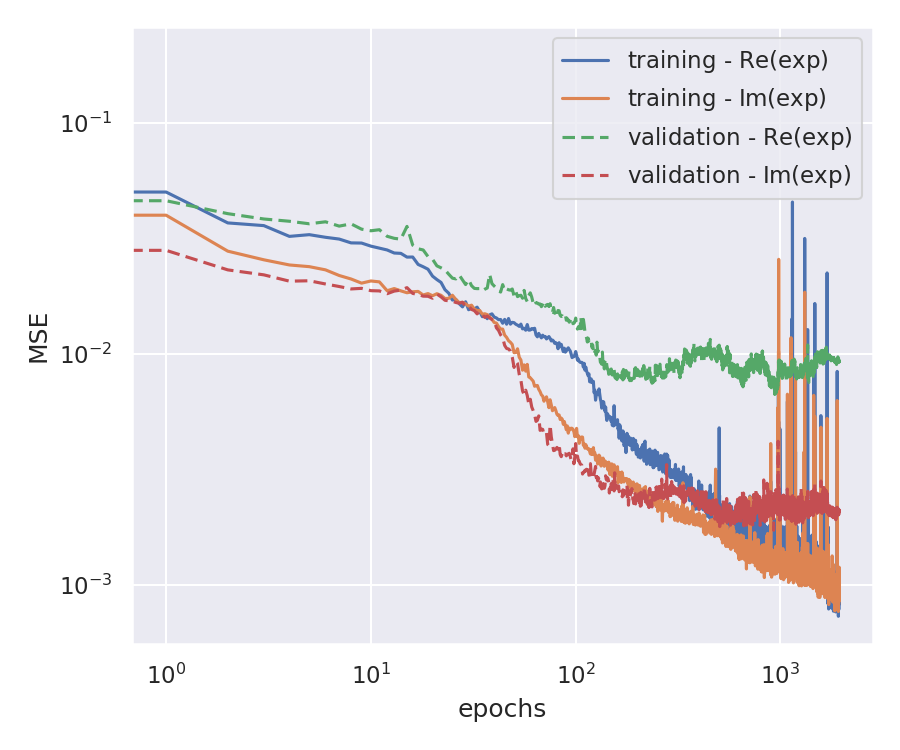

In [83]:
from IPython.display import Image
Image('./img/mse.png', width=480)

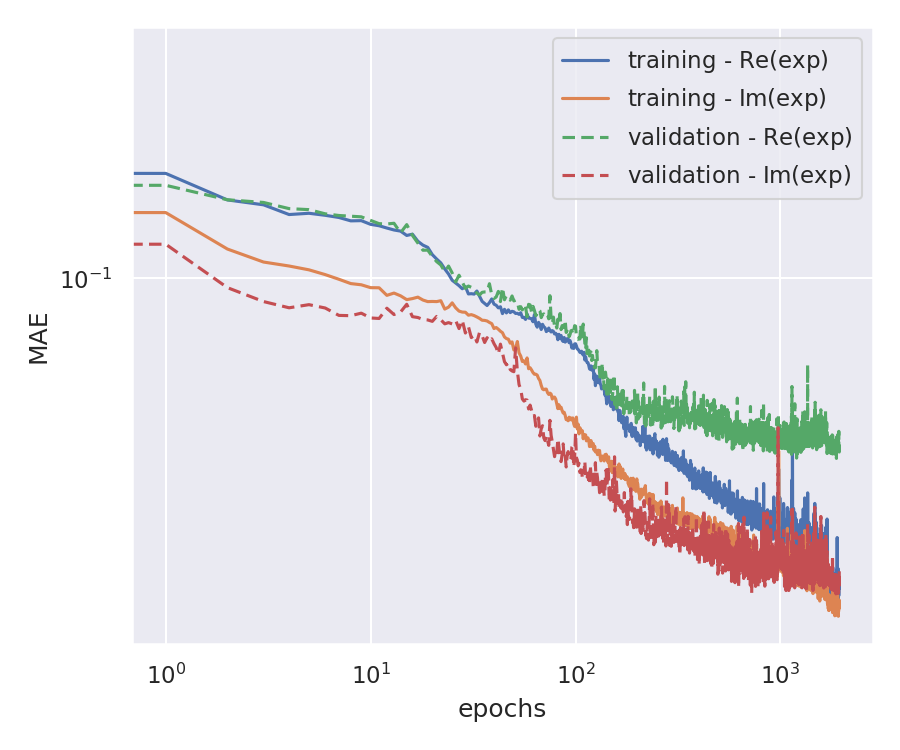

In [84]:
from IPython.display import Image
Image('./img/mae.png', width=480)

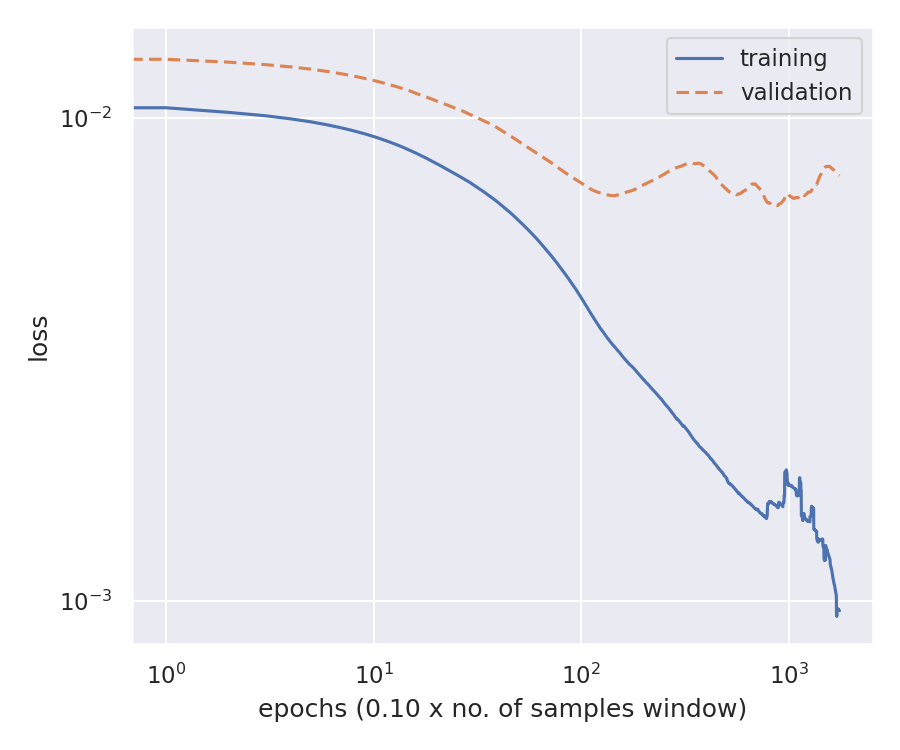

In [85]:
from IPython.display import Image
Image('./img/smooth_loss.png', width=480)

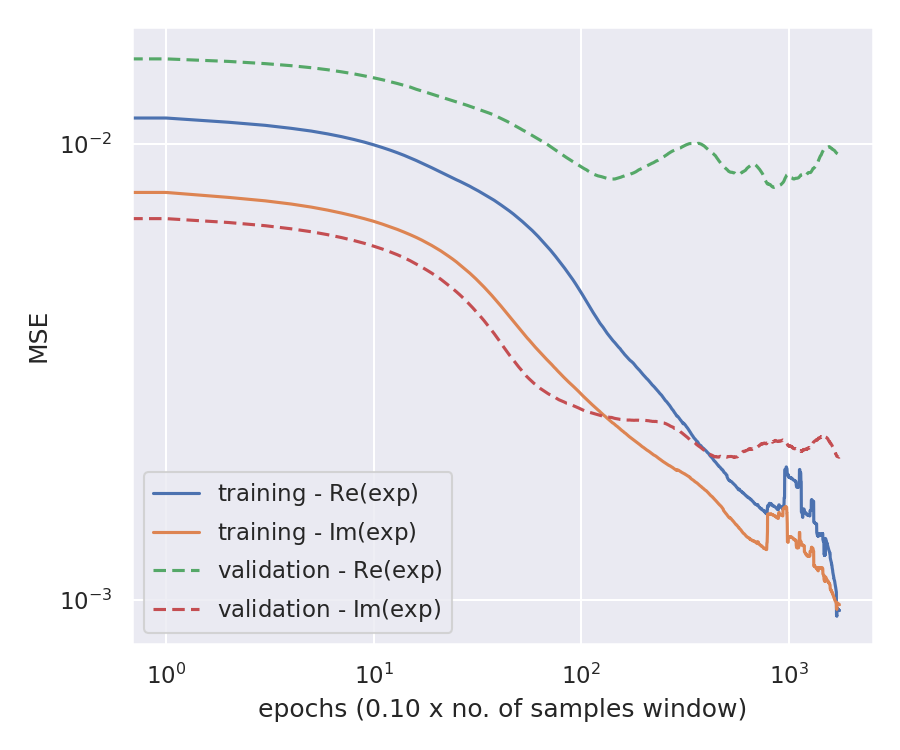

In [86]:
from IPython.display import Image
Image('./img/smooth_mse.png', width=480)

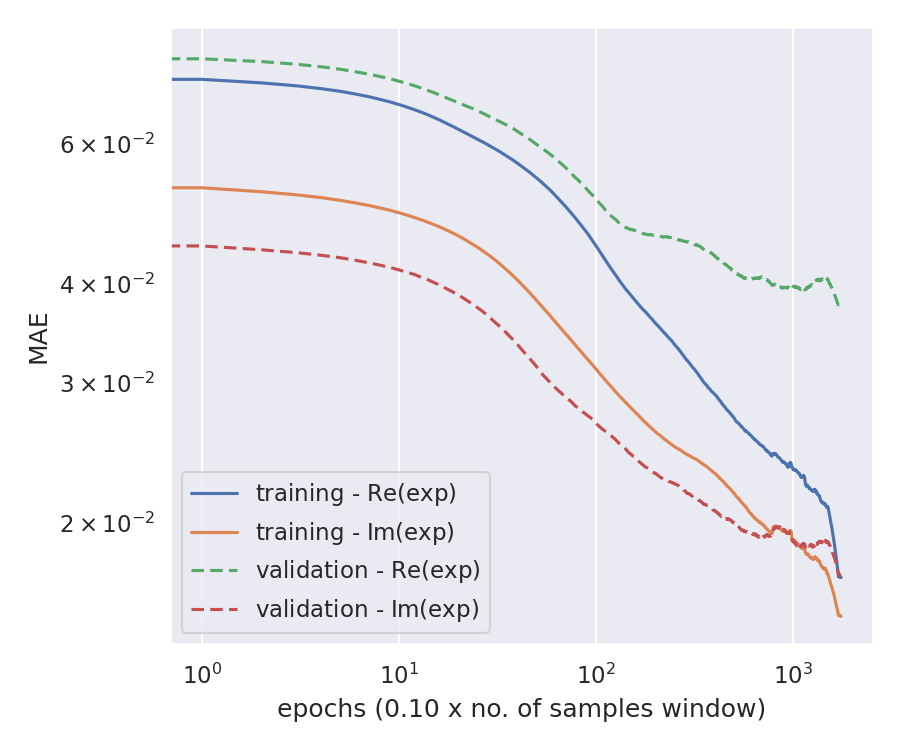

In [87]:
from IPython.display import Image
Image('./img/smooth_mae.png', width=480)

After training we compute the predictions:

In [88]:
!python3 ./scripts/predict.py -tx './data/X_train.csv' -ty './data/y_train.csv' -m './models/ann.h5' -o 'training'

In [89]:
import pandas as pd
pd.read_csv('./data/training_metrics.csv', index_col=0)

,exp_re,exp_im
dof,1891.000000,1891.000000
mse,0.000808,0.000760
mse_ci_low,0.000620,0.000452
mse_ci_high,0.000997,0.001069
mae,0.017541,0.014431
r2,0.984403,0.957392


In [90]:
!python3 ./scripts/predict.py -tx './data/X_val.csv' -ty './data/y_val.csv' -m './models/ann.h5' -o 'validation'

In [91]:
import pandas as pd
pd.read_csv('./data/validation_metrics.csv', index_col=0)

,exp_re,exp_im
dof,232.000000,232.000000
mse,0.006697,0.002130
mse_ci_low,0.002808,0.000254
mse_ci_high,0.010585,0.004006
mae,0.036510,0.019704
r2,0.889863,0.889684


In [92]:
!python3 ./scripts/predict.py -tx './data/X_test.csv' -ty './data/y_test.csv' -m './models/ann.h5' -o 'test'

In [93]:
import pandas as pd
pd.read_csv('./data/test_metrics.csv', index_col=0)

,exp_re,exp_im
dof,232.000000,232.000000
mse,0.009780,0.000844
mse_ci_low,0.002073,0.000388
mse_ci_high,0.017487,0.001300
mae,0.033904,0.015932
r2,0.839572,0.954109


Predictions and metrics can be visually understood by plotting their univariate and multivariate distributions:

In [94]:
!python3 ./scripts/plots.py -gt './data/y_val.csv' -pl './data/y_validation_pred.csv' -o 'validation'

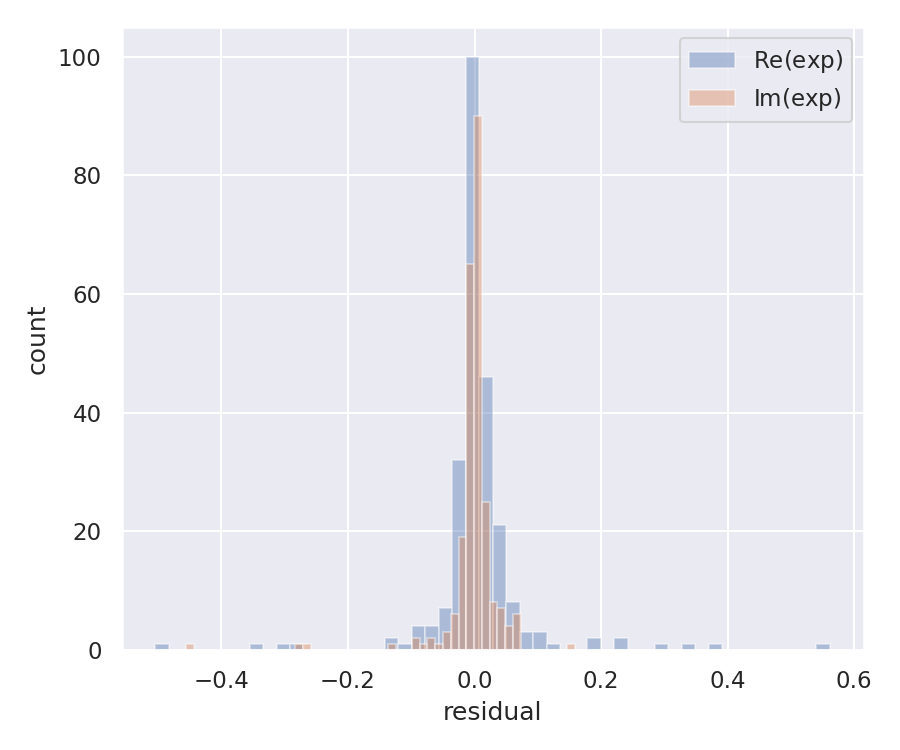

In [95]:
from IPython.display import Image
Image('./img/validation_res_dist.png', width=480)

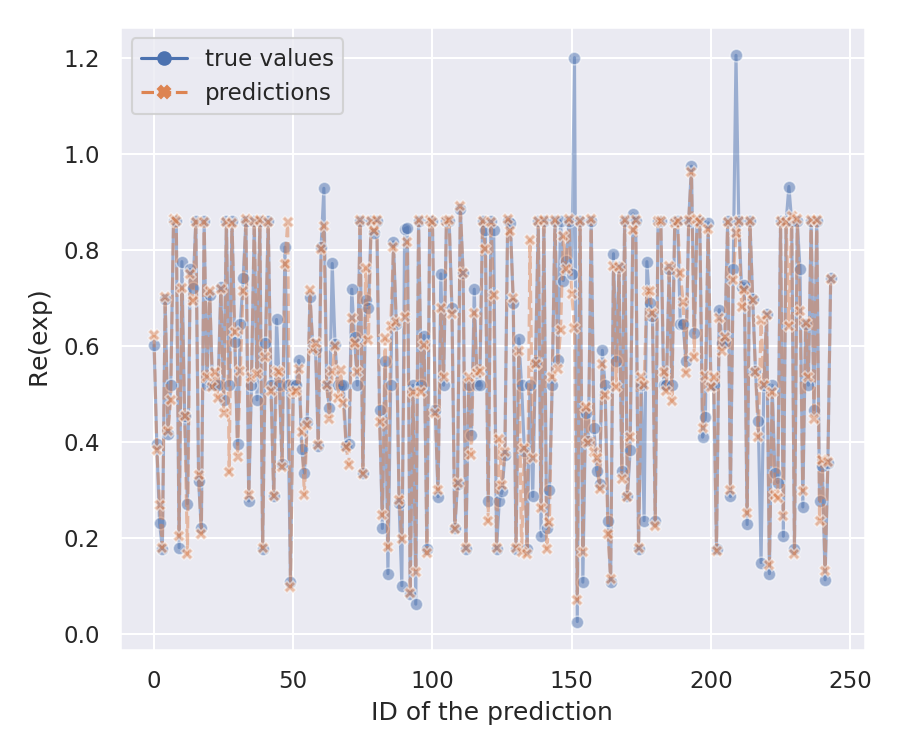

In [96]:
from IPython.display import Image
Image('./img/validation_exp_re_plot.png', width=480)

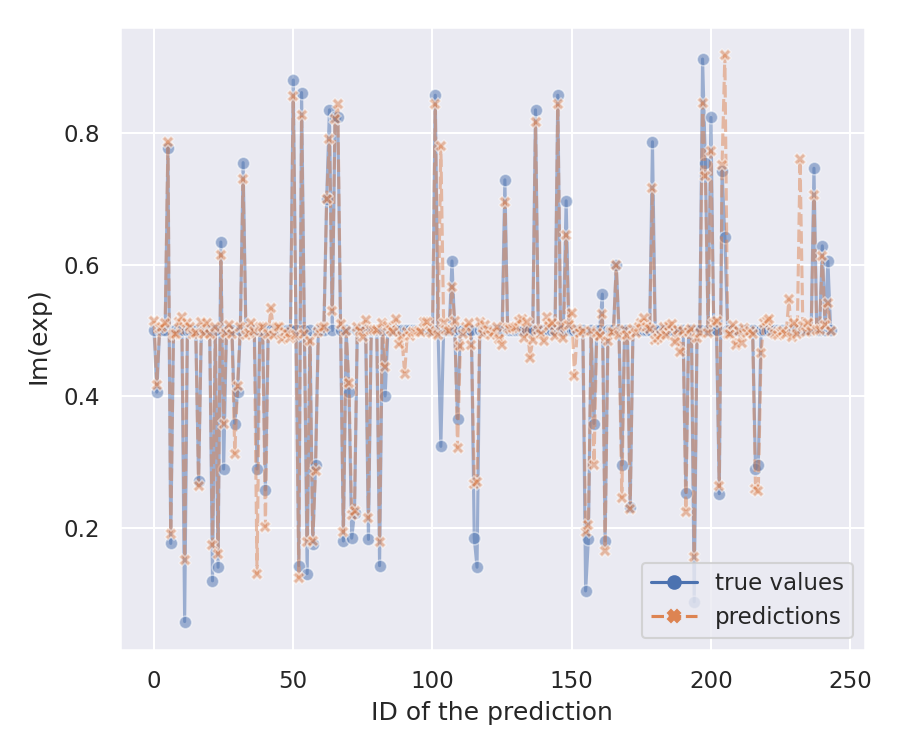

In [97]:
from IPython.display import Image
Image('./img/validation_exp_im_plot.png', width=480)

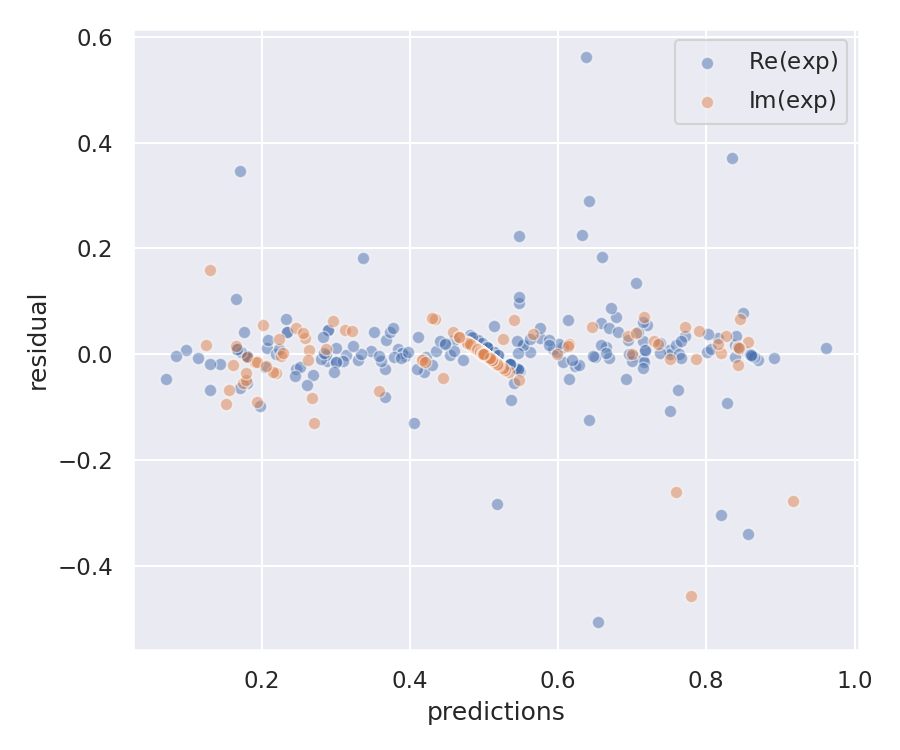

In [98]:
from IPython.display import Image
Image('./img/validation_res_plot.png', width=480)

In [99]:
!python3 ./scripts/plots.py -gt './data/y_test.csv' -pl './data/y_test_pred.csv' -o 'test'

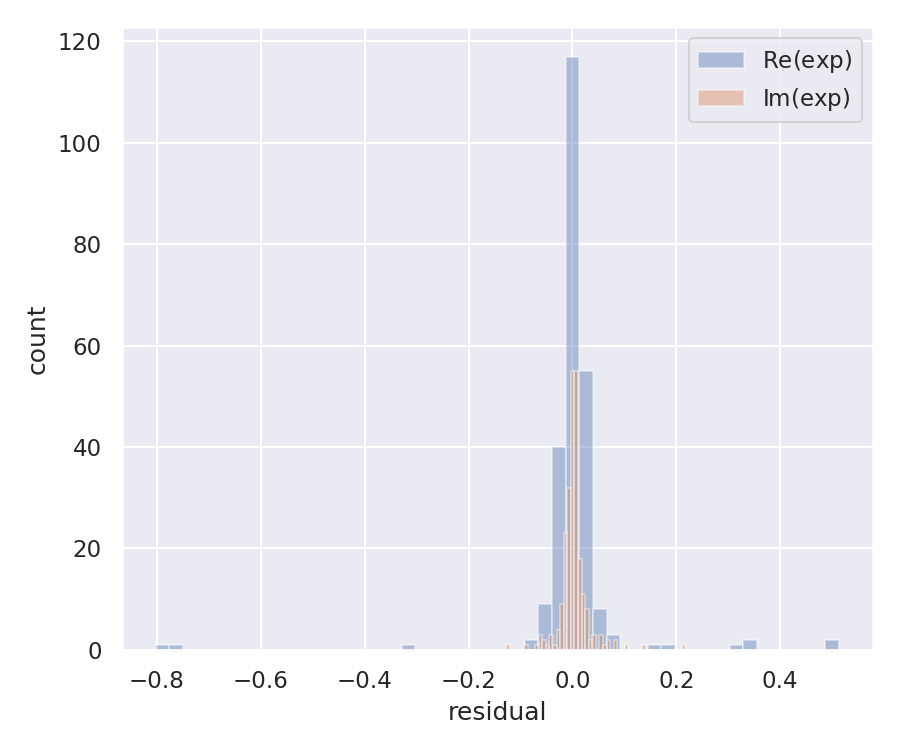

In [100]:
from IPython.display import Image
Image('./img/test_res_dist.png', width=480)

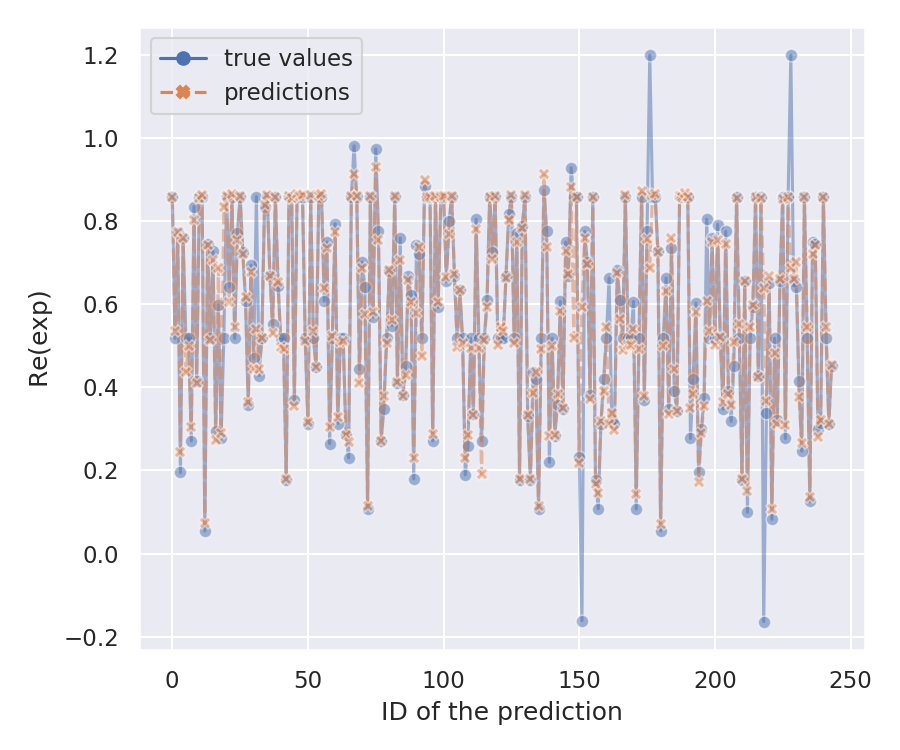

In [101]:
from IPython.display import Image
Image('./img/test_exp_re_plot.png', width=480)

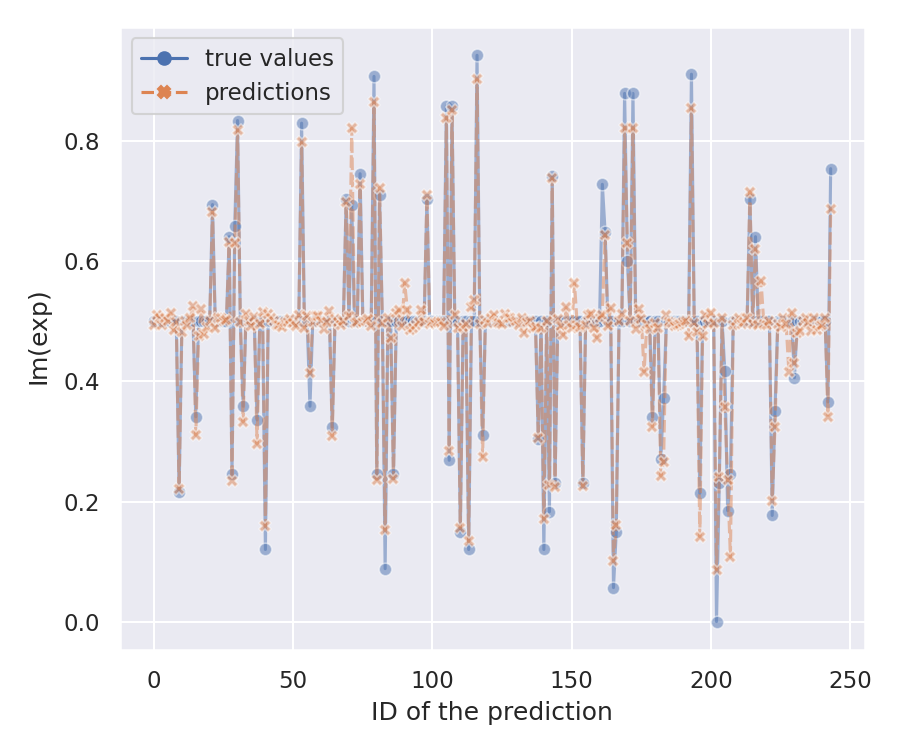

In [102]:
from IPython.display import Image
Image('./img/test_exp_im_plot.png', width=480)

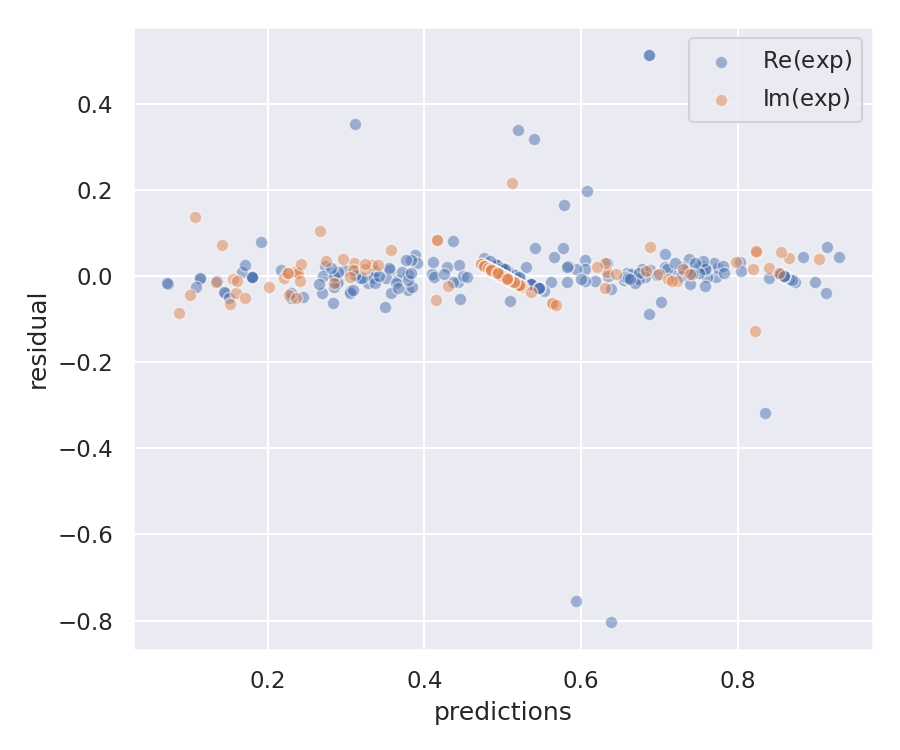

In [103]:
from IPython.display import Image
Image('./img/test_res_plot.png', width=480)

We finally compute the learning curve with different training ratios (always 10% for validation):

In [104]:
#%%script false --no-raise-error

!python3 ./scripts/lc.py -d './data/full.csv' \
                         -m './models/ann.h5' \
                         -ep 20000 -b 32 \
                         -es 1000 -pf 0.3 \
                         -pp 750 -r 123

Training ratio 0.10 finished training in 118.75 seconds.
Training ratio 0.20 finished training in 105.44 seconds.
Training ratio 0.30 finished training in 377.14 seconds.
Training ratio 0.40 finished training in 357.67 seconds.
Training ratio 0.50 finished training in 267.82 seconds.
Training ratio 0.60 finished training in 234.23 seconds.
Training ratio 0.70 finished training in 121.52 seconds.
Training ratio 0.80 finished training in 170.43 seconds.
Training ratio 0.90 finished training in 1777.60 seconds.


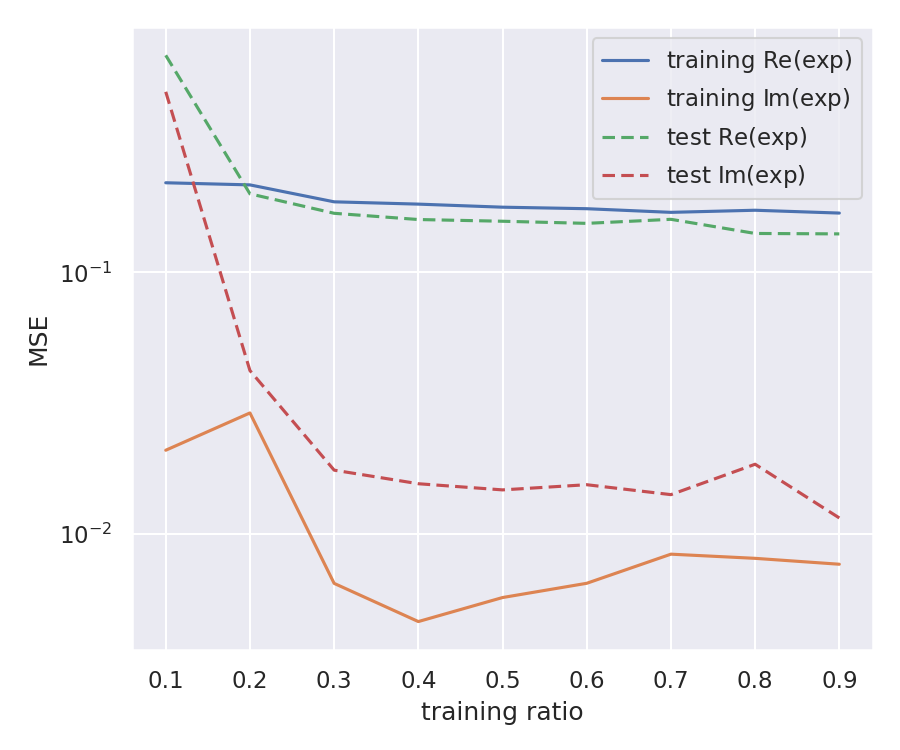

In [105]:
from IPython.display import Image
Image('./img/ann_lc.png', width=480)